# Cold Pool
Laura Gruenburg
laura.gruenburg@noaa.gov
10/15/2024

In [2]:
# Import necessary packages
import xarray as xr
import os
import geopandas as gpd
import READ_EDAB_Utilities_py as reupy
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import pandas as pn

In [3]:
# Load the datasets
# First the debiasted roms + glorys

# Assign directory
directory = "C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/bt_hubert/bt_revised_metadata_032024/"

bt = xr.open_dataset(directory + 'bottom_temp_1959.nc')

# Iterate over files in directory
for file in os.listdir(directory):
    filename = directory + file
    bt_yr = xr.open_dataset(directory + file)
    bt = xr.merge([bt, bt_yr])

In [4]:
# Average monthly for the cold pool indicator
bt_monthly = bt.resample(time = 'MS').mean()

In [5]:
bt_m6 = xr.open_dataset('mom6_bt_cropped.nc')

In [8]:
bt_monthly_hp = bt_monthly.sel(time = slice('1959-01-01','1992-12-31'))

In [9]:
bt_monthly_hp

<xarray.Dataset> Size: 21MB
Dimensions:                             (time: 408, latitude: 103,
                                         longitude: 123)
Coordinates:
  * latitude                            (latitude) float64 824B 35.92 ... 44.42
  * longitude                           (longitude) float64 984B -75.92 ... -...
  * time                                (time) datetime64[ns] 3kB 1959-01-01 ...
Data variables:
    sea_water_temperature_at_sea_floor  (time, latitude, longitude) float32 21MB ...
Attributes: (12/52)
    title:                           Bottom temperature product for the north...
    summary:                         Two ocean products are combined, a regio...
    keywords:                        bottom temperature; northeast U.S. conti...
    Conventions:                     CF-1.7, ACDD-1.3
    uuid:                            8fbe86b8-8d1e-11ed-a1eb-0242ac120002
    source:                          GLORYS12V1 and ROM-NWA
    ...                              ...
    time_coverage_duration:          P1Y0M0DT0H0M0S
    time_coverage_resolution:        24:00:00
    date_created:                    2023-01-09T10:12:00
    date_modified:                   2023-01-09T10:12:00
    date_issued:                     2023-01-09T10:12:00
    date_metadata_modified:          2023-01-09T10:12:00

In [10]:
# bathymetry for mom6
static = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/ocean_static_deptho.nc')

In [11]:
# bathymetry for glorys
bathymetry = xr.open_dataset('GLO-MFC_001_024_mask_bathy.nc')

In [10]:
# regrid bias corrected ROMS 1959 - 1992 to concat to mom6
gl_regrid = np.empty([408,477, 287])
#gl_lons = np.concatenate((np.array(bt_glorys.longitude[:2161]+360), np.array(bt_glorys.longitude[2161:])))
LAT, LON = np.meshgrid(bt_m6.lat.values, bt_m6.lon.values-360)
for i in range(408):
    interp_to_mom6 = RegularGridInterpolator((bt_monthly_hp.latitude.values, bt_monthly_hp.longitude.values), bt_monthly_hp.sea_water_temperature_at_sea_floor[i,:,:].values, bounds_error = False, fill_value = np.nan)
    gl_regrid[i,:,:] = interp_to_mom6((LAT, LON))

In [11]:
bt_hp = xr.Dataset(data_vars = {'tob': (['time','lat','lon'], np.transpose(gl_regrid, (0,2,1)))},
                          coords = {'time': bt_monthly_hp.time,
                                    'lat': bt_m6.lat,
                                    'lon': bt_m6.lon})

In [12]:
bt_m6_hp = xr.merge([bt_hp, bt_m6])

In [13]:
# Load in the shapefile
epu = gpd.read_file('EPU_shape/EPU_NOESTUARIES.shp')
mab = epu[epu.EPU == 'MAB']

$$ Model\, CPI_y =\frac{ \sum_{i=1}^{n} {(T_{i,y} - \bar{T}_{i,\, 1972-2019})}} {n} $$

In [15]:
# 1. crop to the mab

mab_hp = reupy.crop_nd(bt_monthly, 'longitude','latitude', mab)
mab_m6_hp = reupy.crop_nd(bt_m6_hp, 'lon', 'lat', mab)


In [16]:
mab_m6 = reupy.crop_nd(bt_m6, 'lon','lat', mab)

In [17]:
#Get bathymetry in the same region
bathy_match = bathymetry.sel(latitude = slice(np.min(mab_hp.latitude), np.max(mab_hp.latitude)),
                      longitude = slice(np.min(mab_hp.longitude),  np.max(mab_hp.longitude)))

In [18]:
# data needs to be float 32 for this bathymetry step
mab_hp_f32 = xr.Dataset(data_vars = {'tob': (['time','latitude','longitude'], mab_hp.sea_water_temperature_at_sea_floor.data)},
                        coords = {'time': mab_hp.time.values,
                                  'latitude': mab_hp.latitude.values.astype('float32'),
                                  'longitude': mab_hp.longitude.values.astype('float32')})

In [19]:
# 2. filter out everything greater than 200m 
mab_hp_200 = mab_hp_f32.where(bathy_match.deptho<200)
mab_m6_200 = mab_m6_hp.where(static.deptho < 200)

NameError: name 'mab_m6_hp' is not defined

In [20]:
mab_m6200 = mab_m6.where(static.deptho < 200)
mab_hp200 = mab_hp_f32.where(bathy_match.deptho<200)

In [21]:
# 3. Select for june july august september
def is_jjas(month):
    return (month >= 6) & (month <= 9)

mab_hp_200_jjas = mab_hp_200.sel(time=is_jjas(mab_hp_200['time.month']))
mab_m6_200_jjas = mab_m6_200.sel(time=is_jjas(mab_m6_200['time.month']))

NameError: name 'mab_m6_200' is not defined

In [22]:
mab_m6200jjas = mab_m6200.sel(time=is_jjas(mab_m6200['time.month']))
mab_hp200jjas = mab_hp200.sel(time=is_jjas(mab_hp200['time.month']))

In [22]:
# 4. Create the climatology 1972-2019
def is_base_period(year):
    return (year >= 1972) & (year <= 2019)
    
clim_hp = mab_hp_200_jjas.sel(time = is_base_period(mab_hp_200_jjas['time.year'])).mean('time')
clim_m6 = mab_m6_200_jjas.sel(time = is_base_period(mab_m6_200_jjas['time.year'])).mean('time')

In [23]:
# 4. Create the NEW climatology 1993-2019 (overlap of the 1991-2020 new official climatology)
def is_base_period(year):
    return (year >= 1993) & (year <= 2019)

In [25]:
climnew_m6 = mab_m6200jjas.sel(time = is_base_period(mab_m6200jjas['time.year'])).mean('time')
climnew_hp = mab_hp200jjas.sel(time = is_base_period(mab_hp200jjas['time.year'])).mean('time')

In [25]:
# 5. Remove gridcells that are not part of the climatological cold pool
clim_hp_10 = clim_hp.where(clim_hp.tob <= 10)
clim_m6_10 = clim_m6.where(clim_m6.tob <= 10)

In [26]:
climnew_m6_10 = climnew_m6.where(climnew_m6.tob <= 10)
climnew_hp_10 = climnew_hp.where(climnew_hp.tob <= 10)

In [27]:
# 6. Remove gridcells that are not part of the climatological cold pool
mab_hp_200_jjas_10 = mab_hp_200_jjas.where(clim_hp.tob <=10)
mab_m6_200_jjas_10 = mab_m6_200_jjas.where(clim_m6.tob <=10)

In [27]:
mab_m6200jjas10 = mab_m6200jjas.where(climnew_m6.tob <= 10)
mab_hp200jjas10 = mab_hp200jjas.where(climnew_hp.tob <= 10)

In [29]:
# 7. The final calculation
M_CPIy_hp = (mab_hp_200_jjas_10.groupby('time.year').mean('time') - clim_hp_10).sum(['latitude','longitude'])/len(np.where(np.isnan(clim_hp_10.tob) == False)[0])
M_CPIy_m6 = (mab_m6_200_jjas_10.groupby('time.year').mean('time') - clim_m6_10).sum(['lat','lon'])/len(np.where(np.isnan(clim_m6_10.tob) == False)[0])


In [29]:
M_CPIy_newclim_m6 = (mab_m6200jjas10.groupby('time.year').mean('time') - climnew_m6_10).sum(['lat','lon'])/len(np.where(np.isnan(climnew_m6_10.tob) == False)[0])
M_CPIy_newclim_hp = (mab_hp200jjas10.groupby('time.year').mean('time') - climnew_hp_10).sum(['latitude','longitude'])/len(np.where(np.isnan(climnew_hp_10.tob) == False)[0])

In [33]:
m6 = np.empty(27).astype('str')
m6[:] = 'MOM6'

CPInewclim = pn.DataFrame({'Time': M_CPIy_newclim_m6.year,
                           'Value': M_CPIy_newclim_m6.tob*-1,
                           'Source': m6,
                           'Unit': 'Cold Pool Index'}) 

In [31]:
hp = np.empty(62).astype('str')
hp[:] = 'GLORYS'

CPInewclim_hp = pn.DataFrame({'Time': M_CPIy_newclim_hp.year,
                           'Value': M_CPIy_newclim_hp.tob*-1,
                           'Source': hp,
                           'Unit': 'Cold Pool Index'}) 

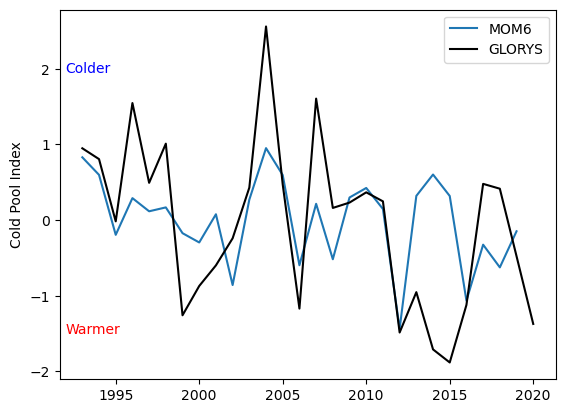

In [37]:
plt.plot(CPInewclim.Time, CPInewclim.Value, label = 'MOM6')
plt.plot(CPInewclim_hp.Time[-28:], CPInewclim_hp.Value[-28:], 'k', label = 'GLORYS')
plt.ylabel('Cold Pool Index')
plt.annotate('Warmer', [1992, -1.5], xycoords = 'data', color = 'red')
plt.annotate('Colder', [1992, 1.95], xycoords = 'data', color = 'blue')
plt.legend()

In [26]:
CPInewclim.to_csv('cold_pool_m6.csv')

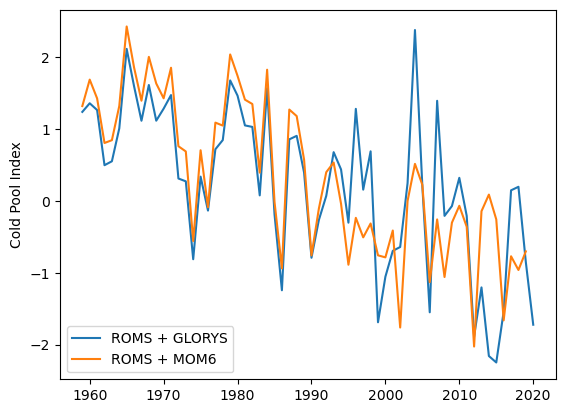

In [22]:
plt.ylabel('Cold Pool Index')
plt.plot(M_CPIy_hp.year, M_CPIy_hp.tob*-1, label = 'ROMS + GLORYS')
plt.plot(M_CPIy_m6.year, M_CPIy_m6.tob*-1, label = 'ROMS + MOM6')
plt.legend()

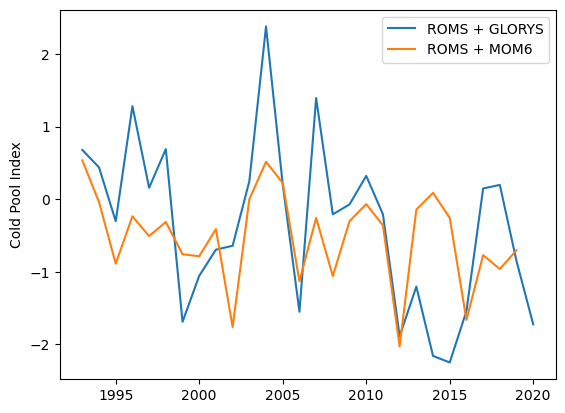

In [25]:
plt.ylabel('Cold Pool Index')
plt.plot(M_CPIy_hp.sel(year = slice(1993, 2023)).year, M_CPIy_hp.sel(year = slice(1993, 2023)).tob*-1, label = 'ROMS + GLORYS')
plt.plot(M_CPIy_m6.sel(year = slice(1993, 2023)).year, M_CPIy_m6.sel(year = slice(1993, 2023)).tob*-1, label = 'ROMS + MOM6')
plt.legend()

In [28]:
import scipy.stats as sio
sio.pearsonr(M_CPIy_hp.sel(year = slice(1993, 2019)).tob*-1,  M_CPIy_m6.sel(year = slice(1993, 2019)).tob*-1)

PearsonRResult(statistic=0.5032057585464728, pvalue=0.007460845148713235)

In [32]:
len(M_CPIy_hp.sel(year = slice(1993, 2019)).tob*-1)

27

In [34]:
m6 = np.empty(27).astype('str')
m6[:] = 'MOM6'
hp = np.empty(27).astype('str')
hp[:] = 'GLORYS'
CPI = pn.DataFrame({'Year': np.append(M_CPIy_m6.sel(year = slice(1993, 2019)).year, M_CPIy_hp.sel(year = slice(1993, 2019)).year),
              'Value': np.append(M_CPIy_m6.sel(year = slice(1993, 2019)).tob*-1, M_CPIy_hp.sel(year = slice(1993, 2019)).tob*-1),
                    'Source': np.append(m6, hp),
              'Unit': 'Cold Pool Index'}) 

In [50]:
plt.plot(CPI.Value)

NameError: name 'CPI' is not defined

In [36]:
CPI.to_csv('cold_pool_index_mom6_revised.csv')


In [24]:
import scipy.stats
scipy.stats.pearsonr(M_CPIy_hp.tob[:-1], M_CPIy_m6.tob)

PearsonRResult(statistic=0.7879347497549554, pvalue=4.88832876390674e-14)

In [57]:
mab_m6_200_jjas

<xarray.Dataset>
Dimensions:  (time: 244, lat: 287, lon: 477)
Coordinates:
  * time     (time) datetime64[ns] 1959-06-01 1959-07-01 ... 2019-09-16
  * lat      (lat) float64 30.05 30.12 30.18 30.24 ... 47.81 47.87 47.93 48.0
  * lon      (lon) float64 261.6 261.6 261.7 261.8 ... 299.7 299.8 299.9 300.0
Data variables:
    tob      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [48]:
def is_jjas(month):
    return (month >= 6) & (month <= 9)

#mab_m6_jjas = mab_m6.sel(time=is_jjas(mab_m6['time.month']))
mab_gl_jjas = mab_hp_200.sel(time=is_jjas(mab_hp_200['time.month'])).sel(time = slice('1993-01-01', '2019-12-31'))

mab_m6only_200_jjas = mab_m6_200_jjas.sel(time = slice('1993-01-01', '2019-12-31'))

NameError: name 'mab_m6_200_jjas' is not defined

C:\Users\Laura.Gruenburg\AppData\Local\anaconda3\envs\mom6_validation_env\Lib\site-packages\cartopy\mpl\geoaxes.py:1601: UserWarning: The following kwargs were not used by contour: 'labels'
  result = super().contour(*args, **kwargs)
C:\Users\Laura.Gruenburg\AppData\Local\anaconda3\envs\mom6_validation_env\Lib\site-packages\cartopy\mpl\geoaxes.py:1601: UserWarning: The following kwargs were not used by contour: 'labels'
  result = super().contour(*args, **kwargs)
C:\Users\Laura.Gruenburg\AppData\Local\anaconda3\envs\mom6_validation_env\Lib\site-packages\cartopy\mpl\geoaxes.py:1601: UserWarning: The following kwargs were not used by contour: 'labels'
  result = super().contour(*args, **kwargs)
C:\Users\Laura.Gruenburg\AppData\Local\anaconda3\envs\mom6_validation_env\Lib\site-packages\cartopy\mpl\geoaxes.py:1601: UserWarning: The following kwargs were not used by contour: 'labels'
  result = super().contour(*args, **kwargs)
C:\Users\Laura.Gruenburg\AppData\Local\anaconda3\envs\mom6_valid

Text(-74, 37.8, 'GLORYS12')

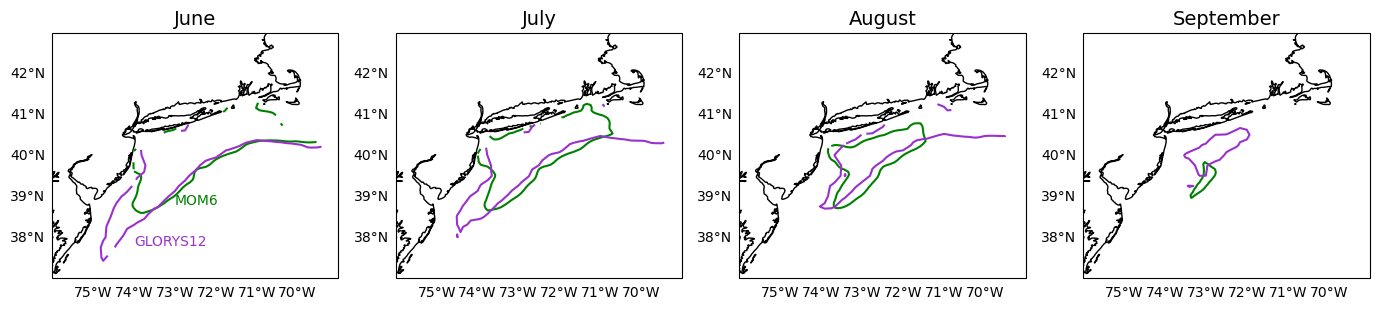

In [61]:
fig, ax = plt.subplots(ncols = 4, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(17, 7))
titles = ['June', 'July', 'August','September']
for i in range(4):
    ax[i].set_extent([-76, -69, 37, 43], crs=ccrs.PlateCarree())
    ax[i].coastlines()
    gl = ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines = False
    c1 = ax[i].contour(mab_m6only_200_jjas.lon, mab_m6only_200_jjas.lat, mab_m6only_200_jjas.tob.groupby('time.month').mean('time').sel(month = i+6), levels = [10], colors= 'green', labels = 'MOM6')
    c2 = ax[i].contour(mab_gl_jjas.longitude, mab_gl_jjas.latitude, mab_gl_jjas.tob.groupby('time.month').mean('time').sel(month = i+6), levels = [10], colors = 'darkorchid', labels = 'GLORYS12')
    ax[i].set_title(titles[i], fontsize = 14)
ax[0].annotate('MOM6', [-73, 38.8], color = 'green')
ax[0].annotate('GLORYS12', [-74, 37.8], color = 'darkorchid')

In [233]:
mab_m6only_200_jjas.to_netcdf('BT_coldpool_mom6.nc')
mab_gl_jjas.to_netcdf('BT_coldpool_glorys.nc')

In [26]:
bt
bt_init = xr.Dataset({'tob': (['init','member','lead','lat','lon'], test_bt)},
                    coords = {'init': bt.init.values,
                              'member': bt.member.values,
                              'lead': bt.lead.values,
                              'lat': bt.lat.values,
                              'lon': bt.lon.values})

NameError: name 'test_bt' is not defined

In [145]:
bt_init

<xarray.Dataset>
Dimensions:  (yr: 1, member: 10, lead: 12, lat: 844, lon: 774)
Dimensions without coordinates: yr, member, lead, lat, lon
Data variables:
    tob      (yr, member, lead, lat, lon) float64 nan nan nan ... nan nan nan

In [187]:
bt2 = xr.open_dataset(directory + 'tob_forecast_i199403.nc')
bt_init2 = xr.Dataset({'tob': (['member','lead','lat','lon'], bt2.tob.values)},
                     coords = {'member': bt2.member.values,
                               'lead': bt2.lead.values,
                               'lat': bt2.lat.values,
                               'lon': bt2.lon.values,
                               'year': bt2.init.values})#,
                     #attrs = {'author': 'Laura'})

In [190]:
bt_init2

<xarray.Dataset>
Dimensions:  (member: 10, lead: 12, lat: 844, lon: 774)
Coordinates:
  * member   (member) int32 1 2 3 4 5 6 7 8 9 10
  * lead     (lead) int32 0 1 2 3 4 5 6 7 8 9 10 11
  * lat      (lat) float64 5.273 5.335 5.398 5.461 ... 57.97 58.04 58.1 58.16
  * lon      (lon) float64 261.6 261.6 261.7 261.8 ... 323.7 323.8 323.8 323.9
    year     datetime64[ns] 1994-03-01
Data variables:
    tob      (member, lead, lat, lon) float32 nan nan nan nan ... nan nan nan
Attributes:
    author:   Laura

In [138]:
xr.merge([bt_init, bt_init2])

MergeError: conflicting values for variable 'tob' on objects to be combined. You can skip this check by specifying compat='override'.

In [37]:
# Load March Initialized forecasts

bt_empty = np.empty([27, 10,12,844,774])
bt_time = np.empty(27)


directory = "C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/tob_forecast/march_init/"

a = 0
# Iterate over files in directory
for file in os.listdir(directory):
    filename = directory + file
    bt_yr = xr.open_dataset(directory + file)
    bt_empty[a,:,:,:,:] = bt_yr.tob.values
    bt_time[a] = pn.to_datetime(bt_yr.init.values).year
    a = a+1

In [30]:
# Load June Initialized forecasts

bt_empty_j = np.empty([27, 10,12,844,774])
bt_time_j = np.empty(27)

directory = "C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/tob_forecast/june_init/"

a = 0
# Iterate over files in directory
for file in os.listdir(directory):
    filename = directory + file
    bt_yr_j = xr.open_dataset(directory + file)
    bt_empty_j[a,:,:,:,:] = bt_yr_j.tob.values
    bt_time_j[a] = pn.to_datetime(bt_yr_j.init.values).year
    a = a+1

In [30]:
# Load December Initialized forecasts

bt_empty_d = np.empty([30, 10,12,844,774])
bt_time_d = np.empty(30)


directory = "C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/Cold Pool/tob_forecast/Dec_init/"

a = 0
# Iterate over files in directory
for file in os.listdir(directory):
    filename = directory + file
    bt_yr = xr.open_dataset(directory + file)
    bt_empty_d[a,:,:,:,:] = bt_yr.tob.values
    bt_time_d[a] = pn.to_datetime(bt_yr.init.values).year
    a = a+1

In [38]:
bt_forecast = xr.Dataset({'tob': (['year','member','lead','lat','lon'], bt_empty)},
                         coords = {'year': bt_time,
                                   'member': bt_yr.member.values,
                                   'lead': bt_yr.lead.values,
                                   'lat': bt_yr.lat.values,
                                   'lon': bt_yr.lon.values})

In [32]:
bt_forecast_j = xr.Dataset({'tob': (['year','member','lead','lat','lon'], bt_empty_j)},
                         coords = {'year': bt_time_j,
                                   'member': bt_yr_j.member.values,
                                   'lead': bt_yr_j.lead.values,
                                   'lat': bt_yr_j.lat.values,
                                   'lon': bt_yr_j.lon.values})

In [31]:
bt_forecast_d = xr.Dataset({'tob': (['year','member','lead','lat','lon'], bt_empty_d)},
                         coords = {'year': bt_time_d,
                                   'member': bt_yr.member.values,
                                   'lead': bt_yr.lead.values,
                                   'lat': bt_yr.lat.values,
                                   'lon': bt_yr.lon.values})

In [39]:
bt_clim = bt_forecast.tob.groupby('lead').mean(['year','member'])
bt_clim_mab = reupy.crop_nd(bt_clim.where(static.deptho < 200), 'lon', 'lat', mab)

In [34]:
bt_clim_j = bt_forecast_j.tob.groupby('lead').mean(['year','member'])
bt_clim_j_mab = reupy.crop_nd(bt_clim_j.where(static.deptho < 200), 'lon', 'lat', mab)

In [32]:
bt_clim_d = bt_forecast_d.tob.groupby('lead').mean(['year','member'])
bt_clim_d_mab = reupy.crop_nd(bt_clim_d.where(static.deptho < 200), 'lon', 'lat', mab)

C:\Users\Laura.Gruenburg\AppData\Local\anaconda3\envs\mom6_validation_env\Lib\site-packages\cartopy\mpl\geoaxes.py:1601: UserWarning: The following kwargs were not used by contour: 'labels'
  result = super().contour(*args, **kwargs)
C:\Users\Laura.Gruenburg\AppData\Local\anaconda3\envs\mom6_validation_env\Lib\site-packages\cartopy\mpl\geoaxes.py:1601: UserWarning: The following kwargs were not used by contour: 'labels'
  result = super().contour(*args, **kwargs)
C:\Users\Laura.Gruenburg\AppData\Local\anaconda3\envs\mom6_validation_env\Lib\site-packages\cartopy\mpl\geoaxes.py:1601: UserWarning: The following kwargs were not used by contour: 'labels'
  result = super().contour(*args, **kwargs)
C:\Users\Laura.Gruenburg\AppData\Local\anaconda3\envs\mom6_validation_env\Lib\site-packages\cartopy\mpl\geoaxes.py:1601: UserWarning: The following kwargs were not used by contour: 'labels'
  result = super().contour(*args, **kwargs)
C:\Users\Laura.Gruenburg\AppData\Local\anaconda3\envs\mom6_valid

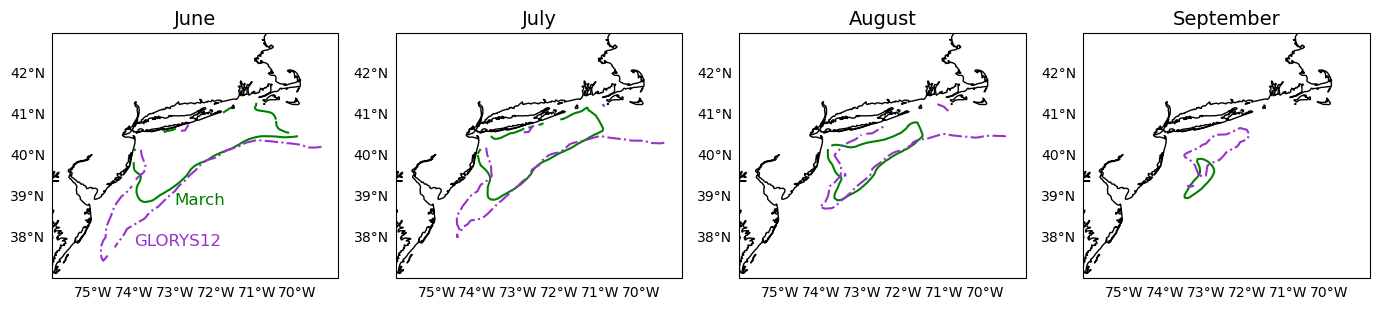

In [49]:
fig, ax = plt.subplots(ncols = 4, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(17, 10), sharey = True)
titles = ['June', 'July', 'August','September']
for i in range(4):
    ax[i].set_extent([-76, -69, 37, 43], crs=ccrs.PlateCarree())
    ax[i].coastlines()
    gl = ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines = False
    ax[i].tick_params(labelsize = 12)
    c1 = ax[i].contour(bt_clim_d_mab.lon, bt_clim_d_mab.lat, bt_clim_d_mab.sel(lead = i+6), levels = [10], colors= 'green', labels = 'March')
    #c1 = ax[i].contour(bt_clim_j_mab.lon, bt_clim_j_mab.lat, bt_clim_j_mab.sel(lead = i), levels = [10], colors= 'darkgoldenrod', labels = 'June')
    c2 = ax[i].contour(mab_gl_jjas.longitude, mab_gl_jjas.latitude, mab_gl_jjas.tob.groupby('time.month').mean('time').sel(month = i+6), levels = [10], colors = 'darkorchid', linestyles = '-.',labels = 'GLORYS12')
    ax[i].set_title(titles[i], fontsize = 14)
ax[0].annotate('March', [-73, 38.8], color = 'green',fontsize = 12)
#ax[0].annotate('June', [-73.5, 38.2], color = 'darkgoldenrod', fontsize = 12)
ax[0].annotate('GLORYS12', [-74, 37.8], color = 'darkorchid', fontsize = 12)
ax[i].tick_params(labelsize = 12)

In [44]:
bt_clim_mab.to_netcdf('BT_coldpool_mom6forecast_march_init.nc')

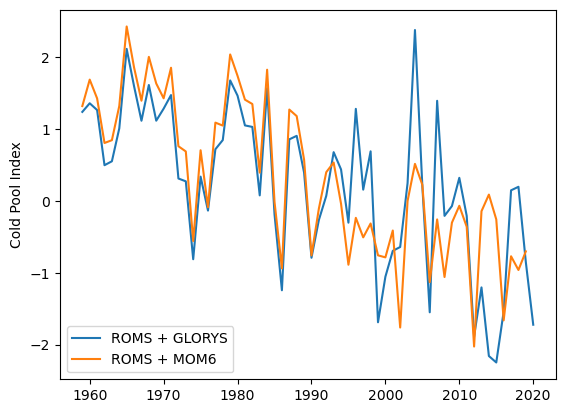

In [53]:
plt.ylabel('Cold Pool Index')
plt.plot(M_CPIy_hp.year, M_CPIy_hp.tob*-1, label = 'ROMS + GLORYS')
plt.plot(M_CPIy_m6.year, M_CPIy_m6.tob*-1, label = 'ROMS + MOM6')
plt.legend()

C:\Users\Laura.Gruenburg\AppData\Local\anaconda3\envs\mom6_validation_env\Lib\site-packages\cartopy\mpl\geoaxes.py:1601: UserWarning: The following kwargs were not used by contour: 'labels'
  result = super().contour(*args, **kwargs)
C:\Users\Laura.Gruenburg\AppData\Local\anaconda3\envs\mom6_validation_env\Lib\site-packages\cartopy\mpl\geoaxes.py:1601: UserWarning: The following kwargs were not used by contour: 'labels'
  result = super().contour(*args, **kwargs)
C:\Users\Laura.Gruenburg\AppData\Local\anaconda3\envs\mom6_validation_env\Lib\site-packages\cartopy\mpl\geoaxes.py:1601: UserWarning: The following kwargs were not used by contour: 'labels'
  result = super().contour(*args, **kwargs)
C:\Users\Laura.Gruenburg\AppData\Local\anaconda3\envs\mom6_validation_env\Lib\site-packages\cartopy\mpl\geoaxes.py:1601: UserWarning: The following kwargs were not used by contour: 'labels'
  result = super().contour(*args, **kwargs)
C:\Users\Laura.Gruenburg\AppData\Local\anaconda3\envs\mom6_valid

Text(-74, 37.8, 'GLORYS12')

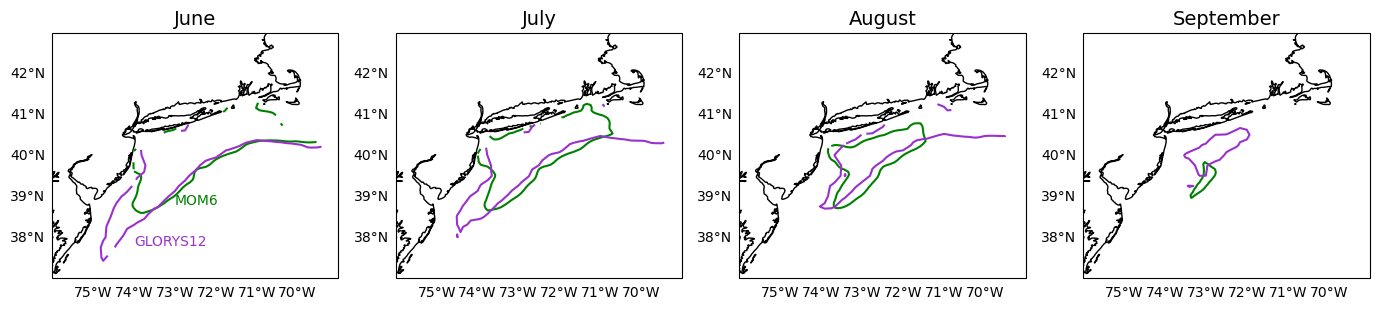

In [62]:
fig, ax = plt.subplots(ncols = 4, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(17, 7))
titles = ['June', 'July', 'August','September']
for i in range(4):
    ax[i].set_extent([-76, -69, 37, 43], crs=ccrs.PlateCarree())
    ax[i].coastlines()
    gl = ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines = False
    c1 = ax[i].contour(mab_m6only_200_jjas.lon, mab_m6only_200_jjas.lat, mab_m6only_200_jjas.tob.groupby('time.month').mean('time').sel(month = i+6), levels = [10], colors= 'green', labels = 'MOM6')
    c2 = ax[i].contour(mab_gl_jjas.longitude, mab_gl_jjas.latitude, mab_gl_jjas.tob.groupby('time.month').mean('time').sel(month = i+6), levels = [10], colors = 'darkorchid', labels = 'GLORYS12')
    ax[i].set_title(titles[i], fontsize = 14)
ax[0].annotate('MOM6', [-73, 38.8], color = 'green')
ax[0].annotate('GLORYS12', [-74, 37.8], color = 'darkorchid')